In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 116552600.54it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74407674.34it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51109947.21it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14356087.99it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.RMSprop(generator.parameters(), lr=0.0002)
optim_d = optim.RMSprop(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [01:01,  1.92it/s]


Epoch 1 of 100
Generator loss: 0.81820333, Discriminator loss: 1.17264032


118it [00:55,  2.14it/s]                         


Epoch 2 of 100
Generator loss: 1.20270655, Discriminator loss: 1.04060902


118it [00:55,  2.11it/s]                         


Epoch 3 of 100
Generator loss: 1.53493761, Discriminator loss: 1.00955947


118it [00:54,  2.16it/s]


Epoch 4 of 100
Generator loss: 1.61836622, Discriminator loss: 1.01831228


118it [00:54,  2.18it/s]


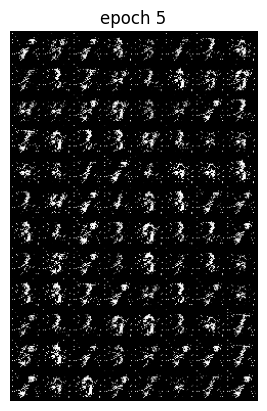

Epoch 5 of 100
Generator loss: 1.89291615, Discriminator loss: 0.90619810


118it [00:54,  2.16it/s]


Epoch 6 of 100
Generator loss: 2.20190417, Discriminator loss: 0.78688572


118it [00:54,  2.15it/s]


Epoch 7 of 100
Generator loss: 2.18203129, Discriminator loss: 0.76541564


118it [00:54,  2.15it/s]


Epoch 8 of 100
Generator loss: 2.35924056, Discriminator loss: 0.67351642


118it [00:55,  2.13it/s]                         


Epoch 9 of 100
Generator loss: 2.53518794, Discriminator loss: 0.59844145


118it [00:55,  2.12it/s]                         


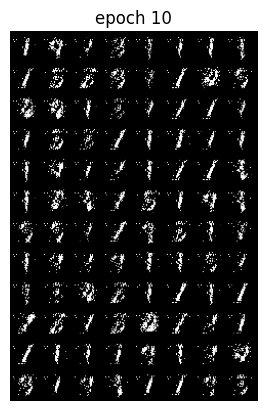

Epoch 10 of 100
Generator loss: 2.49572138, Discriminator loss: 0.54084164


118it [00:55,  2.13it/s]


Epoch 11 of 100
Generator loss: 2.68196975, Discriminator loss: 0.52218141


118it [00:55,  2.12it/s]


Epoch 12 of 100
Generator loss: 2.88399932, Discriminator loss: 0.38395475


118it [00:55,  2.11it/s]


Epoch 13 of 100
Generator loss: 3.01492205, Discriminator loss: 0.38634322


118it [00:55,  2.11it/s]


Epoch 14 of 100
Generator loss: 2.72454437, Discriminator loss: 0.50968483


118it [00:55,  2.12it/s]


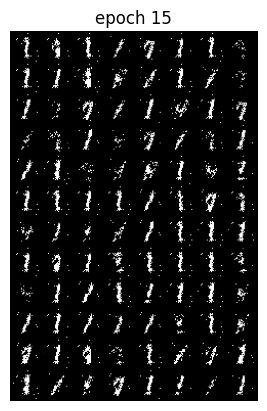

Epoch 15 of 100
Generator loss: 2.47533046, Discriminator loss: 0.53541996


118it [00:54,  2.17it/s]


Epoch 16 of 100
Generator loss: 2.87195476, Discriminator loss: 0.44338045


118it [00:54,  2.16it/s]


Epoch 17 of 100
Generator loss: 2.64197149, Discriminator loss: 0.44209223


118it [00:56,  2.11it/s]


Epoch 18 of 100
Generator loss: 2.62212857, Discriminator loss: 0.50519888


118it [00:55,  2.12it/s]


Epoch 19 of 100
Generator loss: 2.52039947, Discriminator loss: 0.51078048


118it [00:55,  2.11it/s]


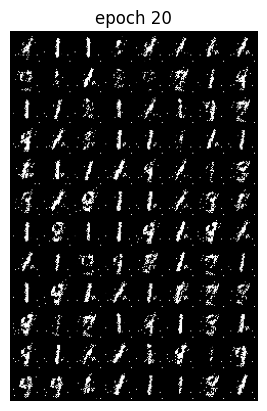

Epoch 20 of 100
Generator loss: 2.42217422, Discriminator loss: 0.55528988


118it [00:55,  2.12it/s]


Epoch 21 of 100
Generator loss: 2.26584502, Discriminator loss: 0.58130575


118it [00:55,  2.12it/s]


Epoch 22 of 100
Generator loss: 2.16709261, Discriminator loss: 0.61867792


118it [00:55,  2.12it/s]


Epoch 23 of 100
Generator loss: 2.18445984, Discriminator loss: 0.59578715


118it [00:55,  2.14it/s]


Epoch 24 of 100
Generator loss: 2.31045283, Discriminator loss: 0.55853045


118it [00:54,  2.15it/s]


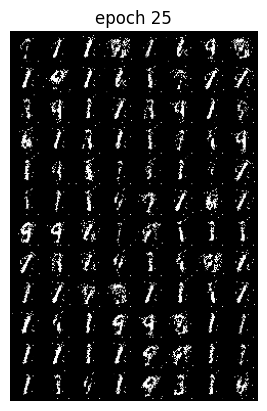

Epoch 25 of 100
Generator loss: 2.29904886, Discriminator loss: 0.54639781


118it [00:55,  2.12it/s]


Epoch 26 of 100
Generator loss: 2.27897662, Discriminator loss: 0.55213651


118it [00:55,  2.11it/s]                         


Epoch 27 of 100
Generator loss: 2.22860058, Discriminator loss: 0.61585484


118it [00:56,  2.11it/s]


Epoch 28 of 100
Generator loss: 2.25053726, Discriminator loss: 0.57069415


118it [00:56,  2.10it/s]


Epoch 29 of 100
Generator loss: 2.20772602, Discriminator loss: 0.60394766


118it [00:56,  2.09it/s]                         


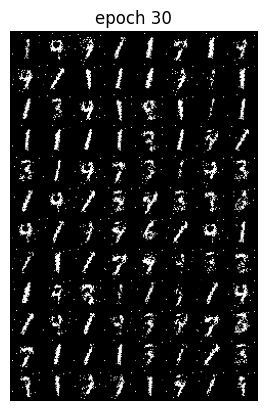

Epoch 30 of 100
Generator loss: 2.29500047, Discriminator loss: 0.55302409


118it [00:56,  2.09it/s]


Epoch 31 of 100
Generator loss: 2.38650150, Discriminator loss: 0.50557264


118it [00:56,  2.09it/s]


Epoch 32 of 100
Generator loss: 2.31613643, Discriminator loss: 0.51904068


118it [00:56,  2.08it/s]


Epoch 33 of 100
Generator loss: 2.21085808, Discriminator loss: 0.56546559


118it [00:56,  2.08it/s]


Epoch 34 of 100
Generator loss: 2.27230172, Discriminator loss: 0.52992630


118it [00:56,  2.08it/s]


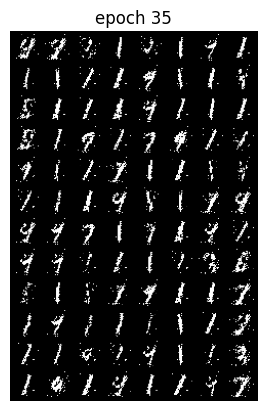

Epoch 35 of 100
Generator loss: 2.25786930, Discriminator loss: 0.54396753


118it [00:56,  2.07it/s]


Epoch 36 of 100
Generator loss: 2.14906139, Discriminator loss: 0.57290579


118it [01:00,  1.95it/s]


Epoch 37 of 100
Generator loss: 2.10485368, Discriminator loss: 0.58960466


118it [00:56,  2.08it/s]


Epoch 38 of 100
Generator loss: 2.10395130, Discriminator loss: 0.58311907


118it [00:56,  2.09it/s]


Epoch 39 of 100
Generator loss: 2.07865175, Discriminator loss: 0.59418449


118it [00:56,  2.10it/s]


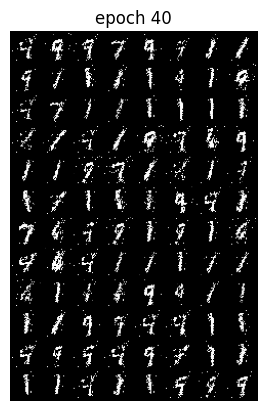

Epoch 40 of 100
Generator loss: 2.11938590, Discriminator loss: 0.58755219


118it [00:55,  2.11it/s]


Epoch 41 of 100
Generator loss: 2.05765387, Discriminator loss: 0.59498259


118it [00:56,  2.11it/s]


Epoch 42 of 100
Generator loss: 2.14016859, Discriminator loss: 0.58362710


118it [00:55,  2.12it/s]


Epoch 43 of 100
Generator loss: 2.09652764, Discriminator loss: 0.58371714


118it [00:55,  2.12it/s]


Epoch 44 of 100
Generator loss: 2.06512815, Discriminator loss: 0.60028588


118it [00:55,  2.12it/s]


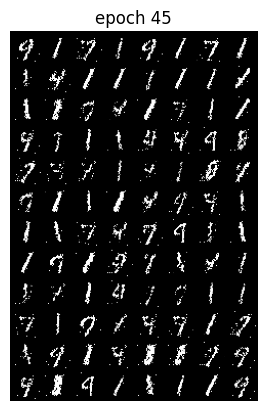

Epoch 45 of 100
Generator loss: 2.10735030, Discriminator loss: 0.58112608


118it [00:56,  2.10it/s]


Epoch 46 of 100
Generator loss: 2.10066093, Discriminator loss: 0.59090494


118it [00:56,  2.11it/s]


Epoch 47 of 100
Generator loss: 2.09933618, Discriminator loss: 0.58487436


118it [00:55,  2.12it/s]


Epoch 48 of 100
Generator loss: 2.11067423, Discriminator loss: 0.59769645


118it [00:55,  2.11it/s]


Epoch 49 of 100
Generator loss: 2.12261786, Discriminator loss: 0.57969701


118it [00:56,  2.10it/s]


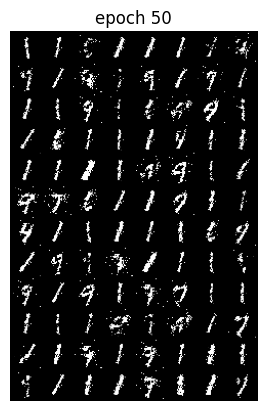

Epoch 50 of 100
Generator loss: 2.05606851, Discriminator loss: 0.60775296


118it [00:56,  2.10it/s]


Epoch 51 of 100
Generator loss: 2.07295827, Discriminator loss: 0.60021401


118it [00:57,  2.06it/s]


Epoch 52 of 100
Generator loss: 2.07825237, Discriminator loss: 0.59487304


118it [00:56,  2.07it/s]


Epoch 53 of 100
Generator loss: 2.10024575, Discriminator loss: 0.59846701


118it [00:56,  2.10it/s]


Epoch 54 of 100
Generator loss: 2.05756066, Discriminator loss: 0.60429131


118it [00:55,  2.12it/s]


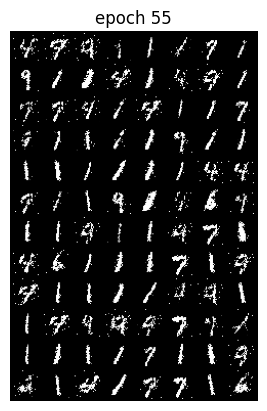

Epoch 55 of 100
Generator loss: 2.04557159, Discriminator loss: 0.60654941


118it [00:55,  2.12it/s]


Epoch 56 of 100
Generator loss: 2.05532444, Discriminator loss: 0.61562583


118it [00:55,  2.11it/s]


Epoch 57 of 100
Generator loss: 2.00930600, Discriminator loss: 0.64318772


118it [00:56,  2.08it/s]


Epoch 58 of 100
Generator loss: 1.87532355, Discriminator loss: 0.69466461


118it [00:57,  2.07it/s]


Epoch 59 of 100
Generator loss: 1.85142409, Discriminator loss: 0.71235992


118it [00:57,  2.06it/s]


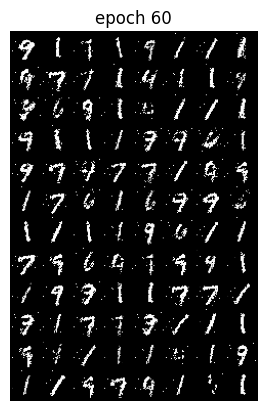

Epoch 60 of 100
Generator loss: 1.90176879, Discriminator loss: 0.68358408


118it [00:56,  2.09it/s]


Epoch 61 of 100
Generator loss: 1.92144737, Discriminator loss: 0.67325503


118it [00:56,  2.08it/s]


Epoch 62 of 100
Generator loss: 1.88723203, Discriminator loss: 0.70266210


118it [00:56,  2.09it/s]


Epoch 63 of 100
Generator loss: 1.88890478, Discriminator loss: 0.72059231


118it [00:56,  2.10it/s]


Epoch 64 of 100
Generator loss: 1.92444397, Discriminator loss: 0.69255879


118it [00:55,  2.11it/s]


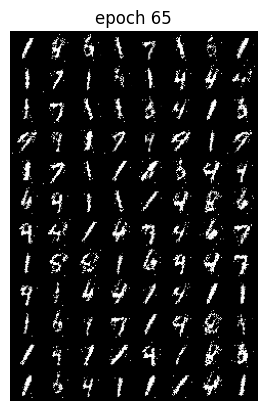

Epoch 65 of 100
Generator loss: 1.85608398, Discriminator loss: 0.71581241


118it [00:55,  2.11it/s]


Epoch 66 of 100
Generator loss: 1.88757966, Discriminator loss: 0.72745007


118it [00:56,  2.10it/s]


Epoch 67 of 100
Generator loss: 1.81385540, Discriminator loss: 0.73827938


118it [00:55,  2.12it/s]


Epoch 68 of 100
Generator loss: 1.84575655, Discriminator loss: 0.74024058


118it [00:55,  2.13it/s]


Epoch 69 of 100
Generator loss: 1.80905131, Discriminator loss: 0.74496449


118it [00:54,  2.15it/s]


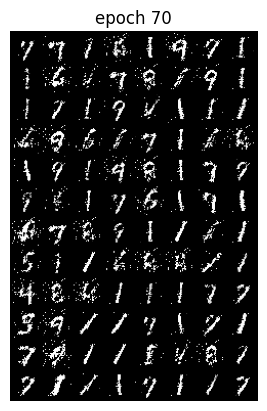

Epoch 70 of 100
Generator loss: 1.81503809, Discriminator loss: 0.75767146


118it [00:55,  2.14it/s]


Epoch 71 of 100
Generator loss: 1.81545104, Discriminator loss: 0.76150668


118it [00:55,  2.11it/s]


Epoch 72 of 100
Generator loss: 1.76032812, Discriminator loss: 0.77445290


118it [00:55,  2.12it/s]


Epoch 73 of 100
Generator loss: 1.78548488, Discriminator loss: 0.77906765


118it [00:56,  2.10it/s]


Epoch 74 of 100
Generator loss: 1.79113899, Discriminator loss: 0.77814591


118it [00:56,  2.10it/s]


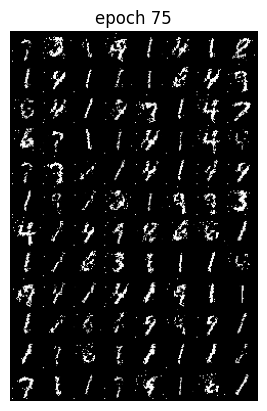

Epoch 75 of 100
Generator loss: 1.79929257, Discriminator loss: 0.76905299


118it [00:56,  2.08it/s]


Epoch 76 of 100
Generator loss: 1.78233444, Discriminator loss: 0.79380104


118it [00:56,  2.10it/s]


Epoch 77 of 100
Generator loss: 1.73216088, Discriminator loss: 0.81740636


118it [00:56,  2.09it/s]


Epoch 78 of 100
Generator loss: 1.70603027, Discriminator loss: 0.82683522


118it [00:55,  2.12it/s]


Epoch 79 of 100
Generator loss: 1.74814224, Discriminator loss: 0.80771672


118it [00:55,  2.13it/s]


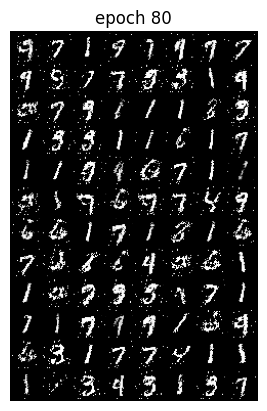

Epoch 80 of 100
Generator loss: 1.62374786, Discriminator loss: 0.86745107


118it [00:55,  2.13it/s]


Epoch 81 of 100
Generator loss: 1.65669407, Discriminator loss: 0.86762427


118it [00:55,  2.11it/s]


Epoch 82 of 100
Generator loss: 1.62578825, Discriminator loss: 0.88072297


118it [00:55,  2.12it/s]


Epoch 83 of 100
Generator loss: 1.62989419, Discriminator loss: 0.86602549


118it [00:55,  2.11it/s]


Epoch 84 of 100
Generator loss: 1.62834943, Discriminator loss: 0.86451638


118it [00:56,  2.10it/s]


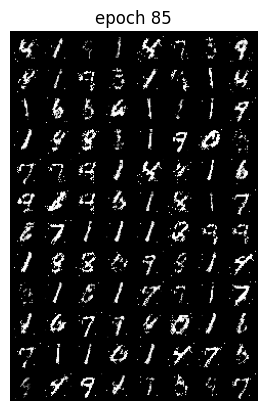

Epoch 85 of 100
Generator loss: 1.61364488, Discriminator loss: 0.89012975


118it [00:56,  2.10it/s]


Epoch 86 of 100
Generator loss: 1.62985596, Discriminator loss: 0.87824909


118it [00:56,  2.09it/s]


Epoch 87 of 100
Generator loss: 1.60376098, Discriminator loss: 0.87578166


118it [00:56,  2.09it/s]


Epoch 88 of 100
Generator loss: 1.53804449, Discriminator loss: 0.91642838


118it [00:56,  2.10it/s]


Epoch 89 of 100
Generator loss: 1.59335965, Discriminator loss: 0.89238465


118it [00:55,  2.12it/s]


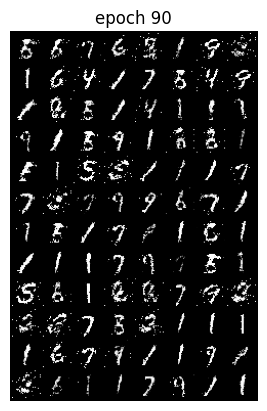

Epoch 90 of 100
Generator loss: 1.58726614, Discriminator loss: 0.91777261


118it [00:55,  2.12it/s]


Epoch 91 of 100
Generator loss: 1.53329738, Discriminator loss: 0.92658431


118it [00:55,  2.13it/s]


Epoch 92 of 100
Generator loss: 1.51533984, Discriminator loss: 0.94538173


118it [00:55,  2.11it/s]


Epoch 93 of 100
Generator loss: 1.54543681, Discriminator loss: 0.92389152


118it [00:56,  2.10it/s]


Epoch 94 of 100
Generator loss: 1.56816155, Discriminator loss: 0.92044536


118it [00:56,  2.10it/s]


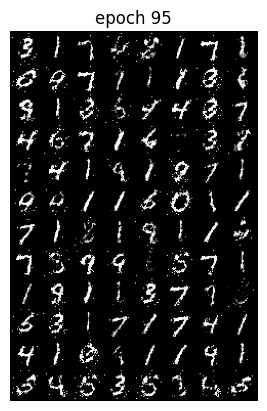

Epoch 95 of 100
Generator loss: 1.53956211, Discriminator loss: 0.92549773


118it [00:56,  2.09it/s]


Epoch 96 of 100
Generator loss: 1.54979872, Discriminator loss: 0.93786144


118it [00:56,  2.09it/s]


Epoch 97 of 100
Generator loss: 1.52161107, Discriminator loss: 0.94543812


118it [00:55,  2.11it/s]


Epoch 98 of 100
Generator loss: 1.53464919, Discriminator loss: 0.92958177


118it [00:56,  2.10it/s]


Epoch 99 of 100
Generator loss: 1.56254801, Discriminator loss: 0.91790069


118it [00:55,  2.13it/s]


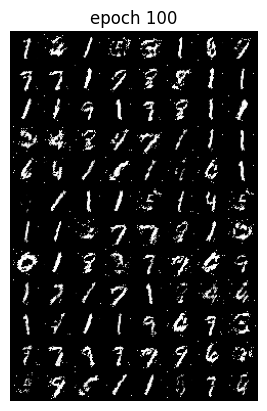

Epoch 100 of 100
Generator loss: 1.55563000, Discriminator loss: 0.92513787


In [14]:
torch.manual_seed(7777)
nz = 128
def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    return criterion(output, true_label)

    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)


    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        # Training the Discriminator
        real_images, _ = data
        optim_d.zero_grad()

        real_labels = torch.ones(real_images.size(0))
        fake_labels = torch.zeros(real_images.size(0))

        real_pred = discriminator(real_images.view(-1, 784))
        # print(real_pred.size, real_labels.size)
        real_loss = discriminator_loss(real_pred.squeeze(), real_labels)
        real_loss.backward()

        noise = torch.randn(real_images.size(0), nz)
        fake_images = generator(noise).detach()
        fake_pred = discriminator(fake_images)
        fake_loss = discriminator_loss(fake_pred.squeeze(), fake_labels)
        fake_loss.backward()

        optim_d.step()
        loss_d += (real_loss.item() + fake_loss.item())

        # Training the Generator
        optim_g.zero_grad()
        noise = torch.randn(real_images.size(0), nz)
        gen_labels = torch.ones(real_images.size(0))

        gen_pred = discriminator(generator(noise))
        gen_loss = generator_loss(gen_pred.squeeze(), gen_labels)
        gen_loss.backward()
        optim_g.step()
        loss_g += gen_loss.item()

        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator_rmsprop.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images_rmsprop.gif', imgs)

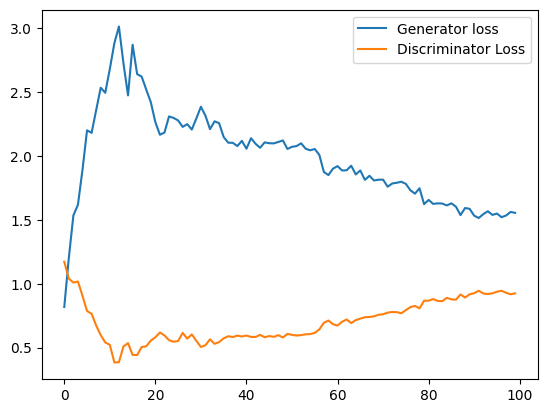

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')